In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as sgeo
%matplotlib inline

# OpenStreetMap

In the previous exercise, we have generated a trip table with origin and destination coordinates. In this exercise, we will make use of OpenStreetMap data to route the individual trips on the networks and show which roads are used by the generated trips.

The following steps will be followed:
- We download OpenStreetMap data for Île-de-France
- We use a tool called `osmosis` to out only the city of Paris (to speed up routing) and to bring the raw data in the right format
- We make use of the library `osmnx` to prepare the network data for routing
- We make use of the library to route all generated trips from the previous exercise on the network
- We plot the flow along the road network that is created by the trips

First, we load in the trip information and the municipality data:

In [2]:
df_trips = gpd.read_parquet("trips.parquet")
df_municipalities = gpd.read_parquet("municipalities.parquet")

**Task**: Filter the municipalities such that only Paris remains in the data set.

In [3]:
### Insert code here
# ...

df_municipalities = df_municipalities[df_municipalities["municipality_id"].str.startswith("75")]

## Preparing OpenStreetMap data

In this part, we will download the OpenStreetMap data, and use `osmosis` to cut and convert it for further processing. Please follow the following steps.

### Osmosis

- Osmosis is a Java-based tool, so you will need to make sure that you have installed a recent Java runtime environment. If you don't have one installed, you may get, for instance, the Adopt OpenJDK: https://adoptopenjdk.net/releases.html

- Next, you can download Osmosis from Github: https://github.com/openstreetmap/osmosis/releases/tag/0.49.2

- When you unpack the archive, you should find a folder called `bin`, which contains the osmosis executable

- On your command line, move into that folder and call `osmosis -v`. You should see some logging output.

**Task**: Adjust the absolute path to the `osmosis` executable here:

In [4]:
osmosis_path = "osmosis"

In [5]:
# Test if osmosis can be called from the notebook
!{osmosis_path} -v

Jan 22, 2024 8:48:44 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Osmosis Version 0.49.2
SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
Jan 22, 2024 8:48:45 PM org.openstreetmap.osmosis.core.TaskRegistrar loadJPFPlugins
FINE: Searching for JPF plugins.
Jan 22, 2024 8:48:45 PM org.openstreetmap.osmosis.core.TaskRegistrar loadJPFPlugins
FINE: Registering the core plugin.
Jan 22, 2024 8:48:45 PM org.openstreetmap.osmosis.core.TaskRegistrar loadJPFPlugins
FINE: Registering the extension plugins.
Jan 22, 2024 8:48:45 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Preparing pipeline.
Jan 22, 2024 8:48:45 PM org.openstreetmap.osmosis.core.pipeline.common.Pipeline prepare
FINE: Building tasks.
Jan 22, 2024 8:48:45 PM org.openstreetmap.osmosis.core.pipeline.common.Pipeline prepare
FINE: Connecting tasks.
Jan 22, 2024 8:48:

### OpenStreetMap data

The whole OpenStreetMap data set is large, so there are providers of smaller cut-outs. One useful source of such cut-outs is GeoFabrik, which provides per-region data sets for France: http://download.geofabrik.de/europe/france.html

- Download the latest data for Île-de-France in `.osm.pbf` format and put the file next to this notebook.

### Preparing the perimeter

We will use `osmosis` to cut the city of Paris from the Île-de-France data. However, `osmosis` only understands a certain format to define a perimeter (`.poly`).

**Task**: First, `dissolve` your municipalities data frame and save it as `paris.gpkg`:

In [6]:
### Insert code here
# ...

df_municipalities.to_file("paris.gpkg")

**Task**:
- In the course material on Github, find a notebook in the `Material/Exercises/Code` folder that is called `Make Polygon.ipynb`.
- Download it, have a look at it and use it to convert `paris.gpkg` into `paris.poly`.

You should now have the `paris.poly` file next to this notebook.

### Cutting the perimeter

Now we make use of `osmosis` to generate a smaller OSM cut-out that only covers Paris. Along the way, we instruct `osmosis` to
- Filter out everything that is not a road ("highway" in OSM speak) and a road within a certain hierachy level
- Filter out everything that is not within `paris.poly`
- Write the output into a new file called `paris.osm`

**Task**: Run the following command to do so. The processing will take a while:

In [7]:
!{osmosis_path} --read-pbf ile-de-france-latest.osm.pbf \
    --tag-filter accept-ways highway=motorway,motorway_link,trunk,trunk_link,primary,primary_link,secondary,secondary_link,tertiary,tertiary_link,residential,residential_link \
    --bounding-polygon file=paris.poly completeWays=yes \
    --used-node --write-xml paris.osm

Jan 22, 2024 8:48:45 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Osmosis Version 0.49.2
SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
Jan 22, 2024 8:48:45 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Preparing pipeline.
Jan 22, 2024 8:48:45 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Launching pipeline execution.
Jan 22, 2024 8:48:45 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Pipeline executing, waiting for completion.
Jan 22, 2024 8:51:01 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Pipeline complete.
Jan 22, 2024 8:51:01 PM org.openstreetmap.osmosis.core.Osmosis run
INFO: Total execution time: 135574 milliseconds.


**Congratulations!** You should now be able to cut a road network for the course project (Exercise 3.3).

## Bonus: Loading the OpenStreetMap data

We are now ready to read the data and make use of it in this notebook. For that, we make use of the `osmnx` library.

Note: During the course, you may also start from the following file for the following sections: [Download](https://drive.google.com/file/d/1eXhJGNnQaP93CgXevxFx1cSqR8IB6s_n/view?usp=sharing)

In [8]:
import osmnx as ox
import networkx as nx

First, we load the data into memory:

In [9]:
graph = ox.graph_from_xml("paris.osm")

Second, we perform various clean-ups that will allow us to use the data as a consistent, connected routing network:

In [10]:
# Self-loop edges
self_loop_edges = list(nx.selfloop_edges(graph))
graph.remove_edges_from(self_loop_edges)

# Isolated nodes
graph = ox.utils_graph.remove_isolated_nodes(graph)

# Find strongly connected component
graph = ox.utils_graph.get_largest_component(graph, strongly = True)

# Speeds and travel times
graph = ox.add_edge_speeds(graph)
graph = ox.add_edge_travel_times(graph)

Third, we obtain a network and clean the data frame to only retain the geometry and the identifiers. Each *edge* in the network is defined through a start *node* and an end *node*.

In [11]:
df_edges = ox.graph_to_gdfs(graph, edges = True, nodes = False)
df_edges = df_edges.reset_index()[["u", "v", "highway", "geometry"]]
df_edges["highway"] = df_edges["highway"].astype(str)

**Task**: Save the data frame as `paris_network.gpkg` and view it in QGIS. You can use the `highway` attribute to show different road types in different colors.

In [12]:
### Insert code here
# ...

df_edges.to_file("paris_network.gpkg")

Fourth, we need to translate our coordinates (origin and destination) into *nodes* of the routing network. We use `osmnx.nearest_nodes` to do so, but we need to take into account the *geographic projection* of our data:

In [13]:
# add origin_node column to our data frame
geometry = df_trips["origin_geometry"].to_crs("EPSG:4326")
df_trips["origin_node"] = ox.nearest_nodes(graph, geometry.x, geometry.y)

# add destination_node column to our data frame
geometry = df_trips["destination_geometry"].to_crs("EPSG:4326")
df_trips["destination_node"] = ox.nearest_nodes(graph, geometry.x, geometry.y)

Fifth, we use `osmnx.shortest_path` to find all shortest paths between the origin nodes and the destination nodes row by row. You may start with a smaller number of $N$ to only route a certain number of trips to speed up the process.

In [14]:
N = 20 # len(df_trips)

routes = ox.shortest_path(
    graph, df_trips["origin_node"].iloc[:N], df_trips["destination_node"].iloc[:N], weight = "travel_time"
)

We have now obtained a list of routes, one for each trip. A route is simply a list of nodes. By always noting down one node in a route, and its successor, we can obtain a data frame that counts the number of traversals of each edge:

In [15]:
df_count = { "u": [], "v": [] }

for route in routes:
    for k in range(1, len(route)):
        df_count["u"].append(route[k - 1])
        df_count["v"].append(route[k])

df_count = pd.DataFrame(df_count)
df_count = df_count.groupby(["u", "v"]).size().reset_index(name = "count")

df_count.sort_values(by = "count", ascending = False).head()

,u,v,count
135,15859483,382052,4
158,21648537,361045,3
307,6198634678,644147,3
308,6225709029,361715,3
64,644145,6198634678,3


Now we can create a geographic data frame that contains the network, and we merge the counts on top:

In [16]:
df_count = pd.merge(df_edges, df_count, on = ["u", "v"])

**Task**: Plot the network using the `count` column in this notebook or in QGIS.

<Axes: >

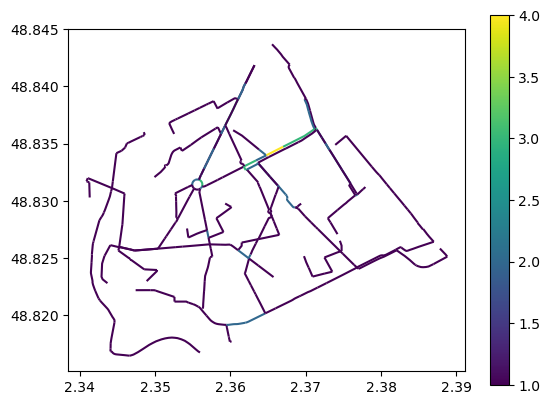

In [17]:
### Insert code here
# ...

df_count.plot("count", legend = True)